In [1]:
import sys
sys.path.insert(0, "/home/gh464/Documents/GitHub/SyMBac/") 
from SyMBac.drawing import raster_cell, OPL_to_FL, convert_to_3D
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import dilation, disk
from skimage.measure import label
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from SyMBac.drawing import raster_cell, OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
from SyMBac.PSF import PSF_generator
import tifffile
from skimage.util import img_as_uint
from skimage.transform import resize
import os

In [2]:
pixel_size = 0.05
scale = 10
pixel_size = pixel_size/scale
def simulate_molecule_counting(N_molecules, length, width):
    OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)
    volume = np.sum(OPL_cell)
    density = N_molecules/volume
    FL_cell = OPL_to_FL(OPL_cell, density = density)
    true_N_molecules = np.sum(FL_cell)
    return FL_cell, true_N_molecules

def calculate_diffraction_limit(wavelength, NA, criterion):
    if criterion == "Rayleigh":
        return 0.61*wavelength/NA
    if criterion == "Abbe":
        return 0.5*wavelength/NA
    if criterion == "Sparrow":
        return 0.47*wavelength/NA

In [3]:
diffraction_limit = calculate_diffraction_limit(wavelength = 0.55,NA = 1.49, criterion = "Rayleigh")/pixel_size

In [4]:
objective_DoF = 0.5 #micron

visible_half_slices = int(((objective_DoF)/pixel_size)/2)

In [5]:
def sample_molecules(N_molecules):
    
    layer_distribution = np.random.choice(layers, p = weights, size = N_molecules)
    FL_cell_3D = np.zeros_like(OPL_cell_3D)
    for i in layer_distribution:
        FL_cell_3D[i] += OPL_to_FL(OPL_cell_3D[i], density = 1/np.sum(OPL_cell_3D[i])).astype(np.uint8)
    FL_cell_3D = FL_cell_3D.astype(np.float32)


    while np.sum(FL_cell_3D) != N_molecules:
        

        layer_distribution = np.random.choice(layers, p = weights, size = N_molecules)
        
        FL_cell_3D = np.zeros_like(OPL_cell_3D)
        for i in layer_distribution:
            FL_cell_3D[i] += OPL_to_FL(OPL_cell_3D[i], density = 1/np.sum(OPL_cell_3D[i])).astype(np.uint8)
        FL_cell_3D = FL_cell_3D.astype(np.float32)
        
        



    half_idx = int(OPL_cell_3D.shape[0]//2)
    FL_cell_DoF = FL_cell_3D[half_idx-int(visible_half_slices):half_idx+int(visible_half_slices)]

    true_N_molecules = np.sum(FL_cell_3D)
    n_molecules_lost_DoF = true_N_molecules - np.sum(FL_cell_DoF)

    projected_cell = FL_cell_DoF.sum(axis=0)

    diffraction_limited_cell = dilation(projected_cell, disk(diffraction_limit/2))

    observed_N_molecules = len(np.unique(label(diffraction_limited_cell)))-1
    n_molecules_lost_diffraction = np.sum(projected_cell) - observed_N_molecules

    return true_N_molecules, observed_N_molecules, n_molecules_lost_DoF, n_molecules_lost_diffraction

In [7]:
samples = 100
test_N_molecules = [5, 10, 15, 20]*samples
length = 5
width = 1
OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)
OPL_cell_3D = convert_to_3D(OPL_cell)
weights = [np.sum(x) for x in OPL_cell_3D]
weights = np.array(weights)/sum(weights)
layers = np.arange(len(OPL_cell_3D))
normal_cell = Parallel(n_jobs=-1)(delayed(sample_molecules)(N) for N in tqdm(test_N_molecules))

  0%|          | 0/400 [00:00<?, ?it/s]

In [8]:
normal_cell_results = pd.DataFrame(normal_cell)
normal_cell_results.columns = ["True N molecules", "Observed N molecules", "N molecules lost to DoF", "N molecules lost to diffraction"]
normal_cell_results["Cell type"] = "1 micron"

/tmp/ipykernel_31487/1374839755.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  normal_cell_results.groupby("True N molecules").mean().plot(kind="bar", stacked = True)


<AxesSubplot:xlabel='True N molecules'>

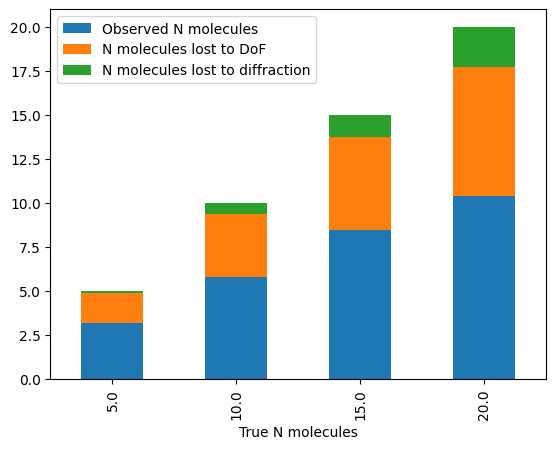

In [9]:
normal_cell_results.groupby("True N molecules").mean().plot(kind="bar", stacked = True)

In [10]:
length = 5
width = 2
OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)
OPL_cell_3D = convert_to_3D(OPL_cell)
weights = [np.sum(x) for x in OPL_cell_3D]
weights = np.array(weights)/sum(weights)
layers = np.arange(len(OPL_cell_3D))
large_cell = Parallel(n_jobs=-1)(delayed(sample_molecules)(N) for N in tqdm(test_N_molecules))

  0%|          | 0/400 [00:00<?, ?it/s]

In [11]:
large_cell_results = pd.DataFrame(large_cell)
large_cell_results.columns = ["True N molecules", "Observed N molecules", "N molecules lost to DoF", "N molecules lost to diffraction"]
large_cell_results["Cell type"] = "2 micron"

/tmp/ipykernel_31487/1597901407.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  large_cell_results.groupby("True N molecules").mean().plot(kind="bar", stacked = True)


<AxesSubplot:xlabel='True N molecules'>

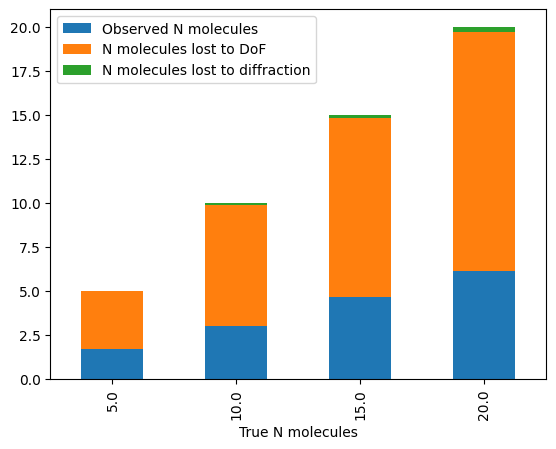

In [12]:
large_cell_results.groupby("True N molecules").mean().plot(kind="bar", stacked = True)

In [13]:
length = 5
width = 1
OPL_cell_MACS = raster_cell(length/pixel_size,width/pixel_size,separation=False)
OPL_cell_3D = convert_to_3D(OPL_cell_MACS)

OPL_cell_3D = resize(OPL_cell_3D, (int(round(OPL_cell_3D.shape[0]*0.6)), int(round(OPL_cell_3D.shape[1]*1.1)), int(round(OPL_cell_3D.shape[2])*2)), anti_aliasing=True, clip=False, preserve_range=True)#.astype(int)
OPL_cell_3D = (OPL_cell_3D > 0) * 1
weights = [np.sum(x) for x in OPL_cell_3D]
weights = np.array(weights)/sum(weights)
layers = np.arange(len(OPL_cell_3D))
MACS_cell = Parallel(n_jobs=1)(delayed(sample_molecules)(N) for N in tqdm(test_N_molecules))

  0%|          | 0/400 [00:00<?, ?it/s]

In [14]:
MACS_cell_results = pd.DataFrame(MACS_cell)
MACS_cell_results.columns = ["True N molecules", "Observed N molecules", "N molecules lost to DoF", "N molecules lost to diffraction"]
MACS_cell_results["Cell type"] = "MACS"

/tmp/ipykernel_31487/2224167130.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  MACS_cell_results.groupby("True N molecules").mean().plot(kind="bar", stacked = True)


<AxesSubplot:xlabel='True N molecules'>

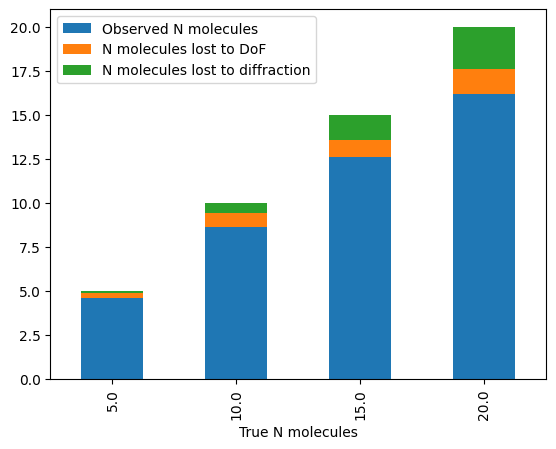

In [15]:
MACS_cell_results.groupby("True N molecules").mean().plot(kind="bar", stacked = True)

In [16]:
all_results = pd.concat([normal_cell_results, large_cell_results, MACS_cell_results])

In [22]:
all_results.to_pickle("sources_of_error.pickle")

In [31]:
samples = 100
test_N_molecules = list(range(1,31))*samples
length = 5
width = 1
OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)
OPL_cell_3D = convert_to_3D(OPL_cell)
weights = [np.sum(x) for x in OPL_cell_3D]
weights = np.array(weights)/sum(weights)
layers = np.arange(len(OPL_cell_3D))
naive_comparison = Parallel(n_jobs=-1)(delayed(sample_molecules)(N) for N in tqdm(test_N_molecules))

  0%|          | 0/3000 [00:00<?, ?it/s]

In [32]:
naive_comparison_results = pd.DataFrame(naive_comparison)
naive_comparison_results.columns = ["True N molecules", "Observed N molecules", "N molecules lost to DoF", "N molecules lost to diffraction"]


<AxesSubplot:xlabel='True N molecules', ylabel='Observed N molecules'>

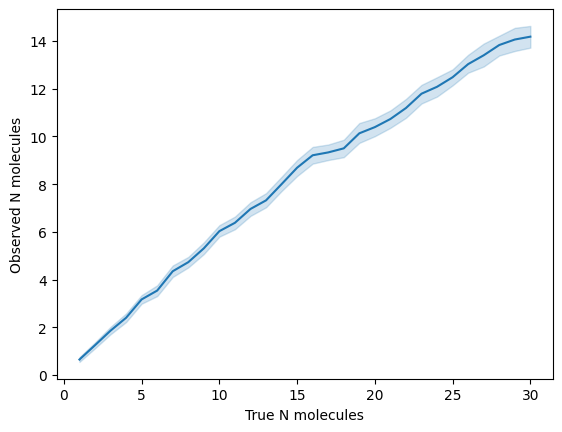

In [33]:
sns.lineplot(data = naive_comparison_results, x = "True N molecules", y = "Observed N molecules")

In [34]:
naive_comparison_results.to_pickle("naive_comparison_results.pickle")